# FourStar Post-Processing & X-Ray Binary Counterpart Extraction

This notebook is used to preview, calibrate, and extract photometric FourStar image data of possible X-ray binary (XRB) counterparts within a presumed error circle indicating the XRB position. This notebook consists of the following sections:

- [Section 1](#section1): Import dependencies, parameters, and data
- [Section 2](#section2): Visualize data and compare with Gaia Data Release 3 (GDR3)
- [Section 3](#section3): Perform astrometric calibration with GDR3
- [Section 4](#section4): Calibrate zero point with 2MASS
- [Section 5](#section5): Extract XRB counterparts
- [Section 6](#section6): Calculate upper limit if there are no detected counterparts
- [Section 7](#section7): De-redden magnitudes and calculate flux density
- [Section 8](#section8): Output: overview and finder chart

More detailed descriptions for each section are provided at the section itself, and guiding text is provided through the notebook as well. In sections 1, 3, 4 and 8 parameters can be set by the user: 

- Section 1 contains parameters to set which data to use and to specify the position of the XRB. These must be set by the user each time this notebook is used.
- Section 3 contains parameters to perform the astrometric calibrations and the option to add a manual pixel shift if there is is a large offset.
- Section 4 contains parameters to perform the zero point calibrations. In general, the default values are okay, but some observations require some fine tuning.
- Section 8 contains parameters to create a good-looking finder chart. This may require some playing with parameters.

It might happen that the image contains counterparts that are visible by eye but undetected by SExtractor, or that sources appear blended. These sources require separate attention with point spread photometry and are not dealt with in this notebook.

Author: Iris Reitsma

## Section  1: Import dependencies, parameters, and data <a class="anchor" id="section1"></a>
All necessary Python libraries are imported, the user sets some variables, and the data (fits and cat files) are opened. The FourStar data is reduced by the FSRED pipeline that is installed on the Linux machine u018918.

In [1]:
"""
Importing all libraries needed.
"""

from astropy.io import fits
import numpy as np
from scipy.odr import *
from astropy.coordinates import SkyCoord
from astroquery.vo_conesearch import ConeSearch
from astroquery.gaia import Gaia
from scipy.ndimage import interpolation
from astropy import units as u
from astropy import constants as c
import astropy.coordinates as coord
from astropy import wcs
import aplpy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.coordinates import ICRS,FK4
import statistics    
import math
import re
import os

In [2]:
""" 
Defining parameters and importing the catalog and image data.

PARAMETERS:
- coords: literature XRB position. If right ascension is in degrees, make 
  sure to change 'u.hourangle' to 'u.deg' in XRB_coo below, and vice versa;
- radius: radius of the error circle around the XRB position in arcsec;
- literature: citation for error circle and telescope/wavelength used for 
  obtaining position/error circle;
- source: name of the XRB. Needs to match the correspondng directory name;
- obs: inumber of the observation;
- band: filter used during the observation: either 'J', 'H', or 'Ks';
- FSRED_dir: the directory in which the FSRED directory is located on your 
  local machine;
- file_name: the name of the star catalog outputted from FSRED;
- nH: the hydrogen column density for the source 
  (use https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/w3nh/w3nh.pl);
- nH_err: the estimated error of nH, if unkown, set to 0;
- %matplotlib: if uncommented, interactive plots are created. However, this 
  does not work when the whole notebook is executed at once, i.e. this only 
  works if each cell is executed seperately.
"""

# Parameters
coords = "17 38 58.300 -44 27 00.00" 
radius = 1
literature = "Liu+2007, optical"
source = "4U_1735-44"
obs = "1153"
band = 'J'
FSRED_dir = "E:/Scriptie/"
file_name = "2018-06-19_J_4U_1735-44_1153_c1-4_58288_18215.mos.fits.cat"
nH = 2.75*10**(21)
nH_err = 0*10**(22) 
#%matplotlib notebook

# Create directory for saving diagnostics if not existing 
if not os.path.exists(FSRED_dir + "FSRED/Diagnostics/" + source):
    os.makedirs(FSRED_dir + "FSRED/Diagnostics/" + source)

# Create coordinate object for XRB position
XRB_coo = SkyCoord(coords, unit=(u.hourangle,u.deg))

# Define figure and filenames for saving 
figname_astrometry = FSRED_dir + "FSRED/Diagnostics/" + source + '/' + source + '_' + band + '_' + obs + "_GDR3.png"
figname_astro_offsets = FSRED_dir + "FSRED/Diagnostics/" + source + '/' + source + '_' + band + '_' + obs + "_astro_offset_hists.png"
figname_mags = FSRED_dir + "FSRED/Diagnostics/" + source + '/' + source + '_' + band + '_' + obs + "_magnitude.png"
figname_finderchart = FSRED_dir + "FSRED/Diagnostics/" + source + '/' + source + '_' + band + '_' + obs + "_finderchart.png"
figname_upplim = FSRED_dir + "FSRED/Diagnostics/" + source + '/' + source + '_' + band + '_' + obs + "_upplim.png"
txtname = FSRED_dir + "FSRED/Diagnostics/" + source + '/' + source + '_' + band + '_' + obs + "_numbers.txt" 
regname = FSRED_dir + "FSRED/Diagnostics/" + source + '/' + source + ".reg"

# Import catalog data
flname = FSRED_dir + "FSRED/u018918_data/" + source + "/" + file_name 
data = fits.getdata(flname,2)

# Checking the data columns that are in the catalogs
print(data.columns)

ColDefs(
    name = 'X_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'Y_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'FLUX_RADIUS'; format = '1E'; unit = 'pixel'; disp = 'F10.3'
    name = 'FLUX_AUTO'; format = '1E'; unit = 'count'; disp = 'G12.7'
    name = 'FLUXERR_AUTO'; format = '1E'; unit = 'count'; disp = 'G12.7'
    name = 'FLUX_MAX'; format = '1E'; unit = 'count'; disp = 'G12.7'
    name = 'ELONGATION'; format = '1E'; disp = 'F8.3'
    name = 'MAG_AUTO'; format = '1E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAGERR_AUTO'; format = '1E'; unit = 'mag'; disp = 'F8.4'
    name = 'FWHM_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F8.2'
    name = 'CLASS_STAR'; format = '1E'; disp = 'F6.3'
    name = 'FLAGS'; format = '1I'; disp = 'I3'
    name = 'VIGNET'; format = '625E'; unit = 'count'; disp = 'G12.7'; dim = '(25, 25)'
    name = 'SNR_WIN'; format = '1E'; disp = 'G10.4'
)


In [3]:
""" 
Opening the fits file and its header to retrieve the WCS solution and 
applying to the X_IMAGE and Y_IMAGE pixel coordinates of the SExtractor 
sources in the cataloge and creating coordinate objects for all of them.

Sometimes a VerifyWarning appears -- you can just ignore that.
"""

# Open the fits file 
hdulist = fits.open(flname[:-4]) 

# Retrieve wcs solution
w = wcs.WCS(hdulist[0].header)
hdulist.close()

# Create coordinate objects for SExtractor sources
xyz = np.array([data['X_IMAGE'], data['Y_IMAGE']])
coo_image = SkyCoord(w.wcs_pix2world(xyz.T,1).T[0]*u.deg, w.wcs_pix2world(xyz.T,1).T[1]*u.deg, frame=ICRS)

print("Number of SExtractor sources:", len(coo_image))

Number of SExtractor sources: 63164


 [astropy.io.fits.verify]


In [4]:
""" 
Create regions file for plotting error circle and future use. 
"""

# Get ICRS coordinates in the right format for regions file
chunks = coords.split(' ')
ra_str = chunks[0] + 'h' + chunks[1] + 'm' + chunks[2] + 's'
dec_str = chunks[3] + 'd' + chunks[4] + 'm' + chunks[5] + 's'
radius_str = str(radius) + '"'

# Write important numbers to file
with open(regname, 'w') as f:
    f.write('# Region file format: DS9 version 4.1 \n')
    f.write('global dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    f.write('ICRS\n')
    f.write('circle({},{},{})'.format(ra_str, dec_str, radius_str) + ' # text+{'+f'{literature}'+'} color=green')
f.close()

## Section 2: Visualize data and compare with Gaia Data Release 3 (GDR3) <a class="anchor" id="section2"></a>
The GDR3 catalog is queried around the XRB position, and GDR3 source positions are plotted in the u018918 FourStar images. Then zoom-ins are made around the XRB position, which allows for inspecting the quality of the images around the XRB, and to see if there is any (local) offset in the image astrometry. 

INFO: Auto-setting vmax to  1.067e+03 [aplpy.core]


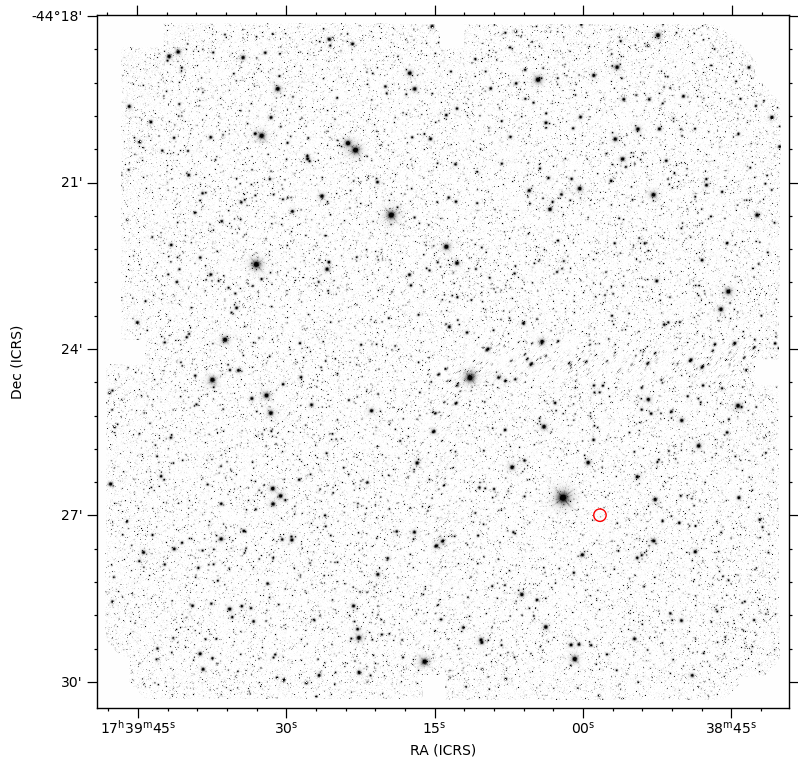

In [5]:
'''
Visualize the FourStar image and show the position of the XRB with a red circle. 
NOTE: the XRB position is not in the center of the image since its usually
located in the center of one of the four chips that together make up the image.
'''

# Plot the FourStar image
gc = aplpy.FITSFigure(flname[:-4])
gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1)

# Plot the XRB source coordinate
gc.show_markers(XRB_coo.ra.deg, XRB_coo.dec.deg, s=80., edgecolor='r', facecolor='none', alpha=1, marker='o')

gc.set_theme('publication')

INFO: Query finished. [astroquery.utils.tap.core]
Number of GAIA sources retrieved: 1000


 [astropy.io.fits.verify]


INFO: Auto-setting vmax to  1.182e+03 [aplpy.core]


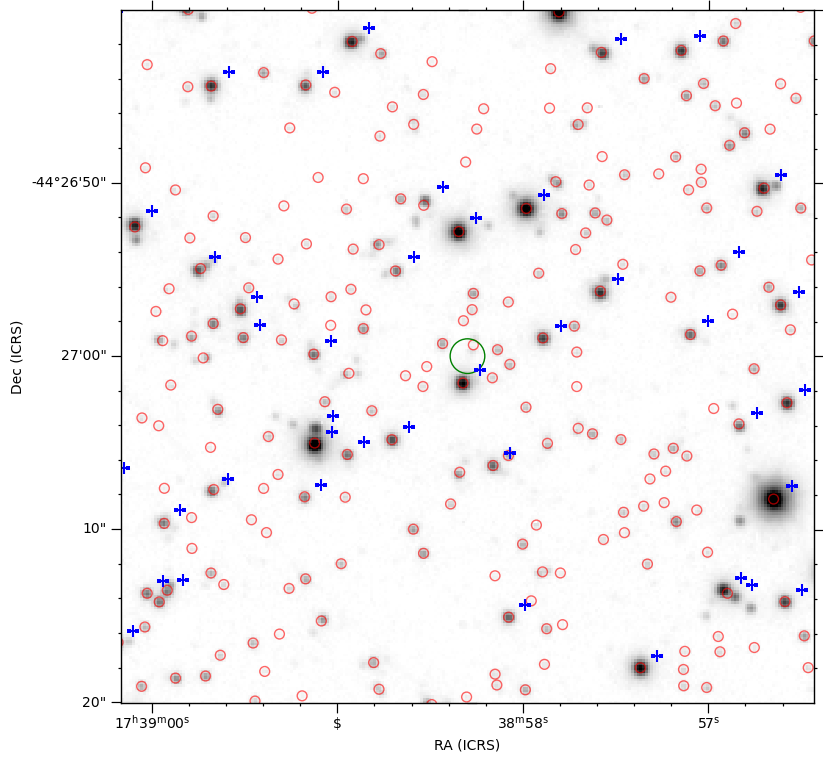

In [6]:
"""
Let's query the GDR3 database and retrieve sources within 
a 5 arcmin circular region around the XRB position, and plot them.
We set the limit of sources to be retrieved on 1000, the query returns
the 1000 stars that are closest to the XRB position. These are also the 
sources that are later used for astrometry.

We produce a first-impression zoom-in on the XRB position, showing the 
surrounding GD3 sources (blue crosses), the literature error circle 
(green circle), and detected sources with SExtractor (red circles) on
u018918. Keep an eye on the following:
- How do the sources look? Is something wrong in the images? 
- The blue crosses may be systematically off from the sources they 
  belong too. This illustrates the necessity for astrometric calibration,
  which happens in the next few notebook cells; 
- How many possible XRB counterparts are there in the error circle?
  Note that if the astrometry is off, the error circle may not include
  the correct counterparts yet. In addition, fainter counterparts may 
  exist that are visible by eye in the image, but are left undetected by 
  SExtractor. Such faint sources require separate attention and are not 
  dealt with in this notebook. 
"""

# Do a search around the XRB position
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select Data Release 3
Gaia.ROW_LIMIT = 1000 # Retrieve at most 1000 Gaia sources
result = Gaia.cone_search_async(XRB_coo, 5 * u.arcmin) # Do a cone search in 5 arcmin TODO niet 1? 

# Transform into pandas dataframe (nicer to handle the table, imo)
gaia_sources = result.get_results().to_pandas()
print("Number of GAIA sources retrieved:", len(gaia_sources))

# Get the source data AND put them into a coordinate object
coo_gaia = SkyCoord(gaia_sources['ra'].values*u.deg, gaia_sources['dec'].values*u.deg,frame=ICRS)

# Plot the FourStar image
gc = aplpy.FITSFigure(flname[:-4])
gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1)

# Plot the FourStar sources
gc.show_markers(coo_image.ra.deg, coo_image.dec.deg, edgecolor='r', facecolor='none', marker='o', s=50, alpha=0.6)

# Plot the XRB source coordinate and recenter on it
gc.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600., edgecolor='g', facecolor='none', alpha=1)
gc.recenter(XRB_coo.ra.deg, XRB_coo.dec.deg, radius=20/3600.)

# Plot the GDR3 sources
gc.show_markers(coo_gaia.ra.deg, coo_gaia.dec.deg, edgecolor='b', facecolor='b', marker='+', s=80, alpha=1,label="GDR3")

gc.set_theme('publication')
gc.savefig(figname_astrometry)

## Section 3: Perform astrometric calibration with GDR3 <a class="anchor" id="section3"></a>
Corrections for any offsets in the astrometry are made. This ensures that the error circle contains the correct counterparts. The astrometry is calibrated by using the queried GDR3 catalog, then performing nearest neighbour matching, and extracting the distance vector between each GDR3 source and its FourStar counterpart. The average distance vector between all GDR3 sources and their FourStar counterparts then represents the local astrometric offset. 

In [7]:
"""
Parameters for astrometric calibration.
"""

search_radius = 0.5 # The radius of a circle around each GDR3 source within which all possible 
                    # FourStar counterparts of this source are collected in arcsec. Default: 0.5
astro_error_level = 0.90 # The inclusion level of the outputted astrometric error. default: 0.90

INFO: Auto-setting vmax to  1.001e+03 [aplpy.core]


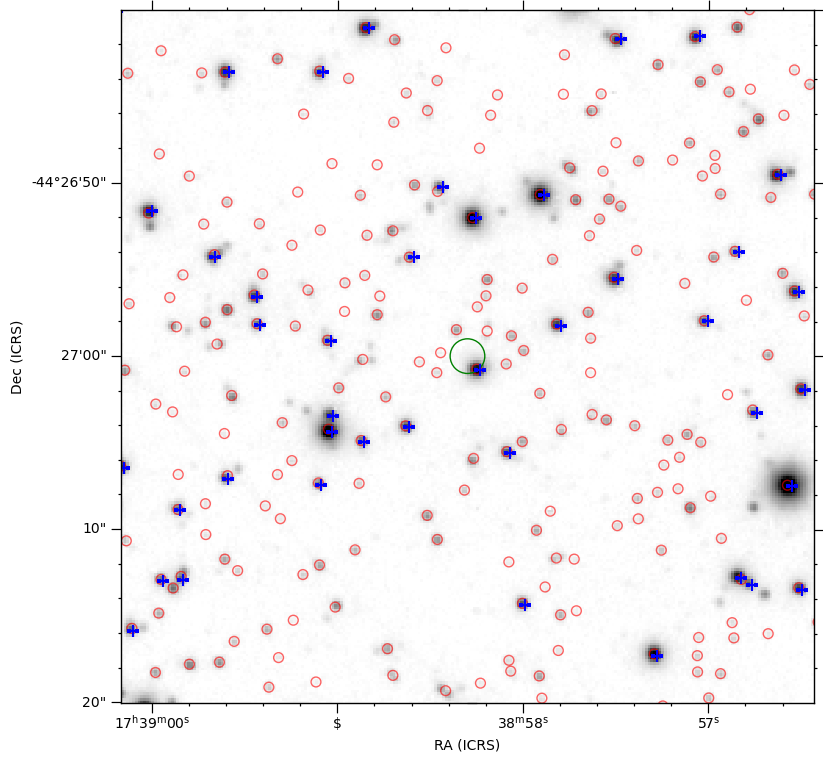

In [8]:
"""
Use the image above estimate if there is a systematic offset. If there 
is a large offset (about >0.5"), immediately applying the astrometric 
calibration will fail since FourStar sources could be wrongly matched 
with GDR3 sources.

If the offset is not that large, set add_manual_shift to False and 
continue with running the next cells. 

If the offset is large, set add_manual_shift to True and estimate the 
shift in pixels by adjusting hor_pix_shift_manual and ver_pix_shift_manual. 
Inspect the resulting image. If the astrometric offset looks better, 
continue with the notebook. If there still seems to be a systematic offset, 
try changing the values for these parameters. 
"""

add_manual_shift = True # Default: False

if add_manual_shift == False: 
    hor_pix_shift_manual = 0
    ver_pix_shift_manual = 0

if add_manual_shift == True:
    hor_pix_shift_manual = 5 
    ver_pix_shift_manual = 5

    # Apply shift to SExtractor source regions
    pix_image_hor_astrocal = data['X_IMAGE'] + hor_pix_shift_manual
    pix_image_ver_astrocal = data['Y_IMAGE'] + ver_pix_shift_manual

    # Define new coordinate objects based on shift
    xyz = np.array([pix_image_hor_astrocal, pix_image_ver_astrocal])
    coo_image= SkyCoord(w.wcs_pix2world(xyz.T,1).T[0]*u.deg, w.wcs_pix2world(xyz.T,1).T[1]*u.deg, frame=ICRS)

    # Apply shift to image and store as a new FITS file
    im, hdr = fits.getdata(flname.split(".cat")[0], header=True)
    im = interpolation.shift(im,[ver_pix_shift_manual, hor_pix_shift_manual])
    reg = fits.PrimaryHDU()
    reg.data = im
    reg.header = hdr
    del hdr['WEIGHT'] # Deleting these cards from the calibrated image header supresses
    del hdr['TWEIGHT'] # a VerifyError that otherwise would cause trouble here
    del hdr['GWEIGHT']
    reg.writeto(flname.split(".fits")[0] + "_astrocal_manual.fits", overwrite=True)

    # Image stamp from manually shifted image:
    gc2 = aplpy.FITSFigure(flname.split(".fits")[0] + "_astrocal_manual.fits")
    gc2.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1)

    # Plot the FourStar sources
    gc2.show_markers(coo_image.ra.deg, coo_image.dec.deg, edgecolor='r', facecolor='none', marker='o', s=50, alpha=0.6)

    # Plot the XRB source
    gc2.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600., edgecolor='g', facecolor='none', alpha=1)

    # Recentering on XRB source
    gc2.recenter(XRB_coo.ra.deg, XRB_coo.dec.deg, radius=20/3600.)

    # Plot the GDR3 sources
    gc2.show_markers(coo_gaia.ra.deg, coo_gaia.dec.deg, edgecolor='b', facecolor='b', marker='+', s=80, alpha=1,label="GDR3")
    
    gc2.set_theme('publication')

In [9]:
"""
Perform nearest neighbour matching between the position catalogs of GDR3 and 
u018918 (FourStar). NOTE: how well the matches between the GDR3 and FourSTAR 
catalogs are, depends on the accuracy of the astrometry between GDR3 and the 
FourStar sources, and on the crowdedness of the field. This means that possibly 
(many) mismatches occur, we tried to fix this as much as possible with applying 
the manual shift in the previous cell. 

We match the largest catalog (FourStar) to the smallest catalog (GDR3, 1000 
sources requested). This ensures that for each star in the largest catalog, a 
counterpart in the smallest catalog is assigned. 

The idx_* list below contains an index for every position in the largest catalog 
referring to the most nearby position in the smallest catalog; the d2d_* list 
contains the corresponding angular separations; and the d3d_* list contains the 3D 
distances between stars. The latter is not used in this notebook, and is also 
meaningless, as we haven't provided distances for the stars.
"""

# Match u018918 to Gaia 
idx_gaia, d2d_gaia, d3d_gaia = coo_image.match_to_catalog_sky(coo_gaia)

In [10]:
"""
Perform the astrometric calibration for the u018918 data. The following
steps are performed, and indicated in the code flow:

STEP 1: Quality cut the matched sources based on distance and magnitude:
Only use matches which have a distance <search_radius, and only use sources with 
magnitudes <20 because often only the brightest stars in our image
are detected by GDR3.

STEP 2: Compute the offset in RA and DEC for each of the matched sources and 
convert this to horizontal and vertical pixel distance. Store these values
in lists. 

STEP 3: Compute the median angular distance vector and pixel distance vector 
components and print the results. 

STEP 4: Apply the astrometric offset to the FourStar source regions of u018918
and transform into calibrated sky positions. Then, apply this offset to the 
u018918 image by shifting the image. The shifted image is stored as a new FITS 
file (*_astrocal.fits).

STEP 5: Given the calibrated FourStar positions, compute the astrometric error
by computing the angular separations between the GDR3 positions and the 
calibrated positions of their FourStar counterparts. Then, the astrometric 
error is computed as the separation at which a fraction of 'astro_error_level' 
of the separations is included.
"""

# STEP 1: quality cut
quality_cut_index = (d2d_gaia.arcsec < search_radius) & (gaia_sources.phot_g_mean_mag[idx_gaia] <20.) & (data['MAG_AUTO'] < 20.)
d2d_gaia_cut = d2d_gaia[quality_cut_index]
coo_image_cut = coo_image[quality_cut_index]
coo_gaia_cut = coo_gaia[idx_gaia][quality_cut_index]


# STEP 2: compute offsets 
# Lists to store the components of the pixel distance and angular distance.
ra_diff_list = []
dec_diff_list = []
hor_pixdiff_list = []
ver_pixdiff_list = []

# Loop over matches to compute and store offsets
for i in range(len(d2d_gaia_cut)):
    
    # Calculate difference in RA and DEC
    gaia_coord = coo_gaia_cut[i]
    image_coord = coo_image_cut[i]
    ra_diff_list.append(gaia_coord.ra - image_coord.ra)
    dec_diff_list.append(gaia_coord.dec - image_coord.dec)
    
    # Convert coordinates to pixels and calculate pixel difference 
    gaia_pix_hor, gaia_pix_ver = w.wcs_world2pix(gaia_coord.ra, gaia_coord.dec, 1, ra_dec_order=True)
    image_pix_hor, image_pix_ver = w.wcs_world2pix(image_coord.ra, image_coord.dec, 1, ra_dec_order=True)
    hor_pixdiff_list.append(gaia_pix_hor - image_pix_hor)
    ver_pixdiff_list.append(gaia_pix_ver - image_pix_ver)    
    
    
# STEP 3: compute median pixel distance and angular distance vectors
ra_shift = statistics.median(ra_diff_list) 
dec_shift = statistics.median(dec_diff_list) 
hor_pix_shift = np.median(hor_pixdiff_list) 
ver_pix_shift = np.median(ver_pixdiff_list) 
ra_diffvals_list = [i.value * 3600 for i in ra_diff_list]
dec_diffvals_list = [i.value * 3600 for i in dec_diff_list]
    
print("Number of Gaia sources queried", len(coo_gaia))
print("Number of Gaia sources with reliable FourStar counterpart: ", len(coo_gaia[idx_gaia][quality_cut_index]))
print("Horizontal pixel shift:", hor_pix_shift, np.std(hor_pixdiff_list))
print("Vertical pixel shift:", ver_pix_shift, np.std(ver_pixdiff_list))
print("~RA shift:", ra_shift, np.std(ra_diffvals_list))
print("~Dec shift:", dec_shift, np.std(dec_diffvals_list))


# STEP 4:    
# Apply shift to SExtractor source regions
pix_image_hor_astrocal = data['X_IMAGE'] + hor_pix_shift_manual + hor_pix_shift 
pix_image_ver_astrocal = data['Y_IMAGE'] + ver_pix_shift_manual + ver_pix_shift

# Apply shift to image and store as a new FITS file 
if add_manual_shift == True:
    im, hdr = fits.getdata(flname.split(".fits")[0] + "_astrocal_manual.fits", header=True)
    im = interpolation.shift(im,[ver_pix_shift, hor_pix_shift])
    reg = fits.PrimaryHDU()
    reg.data = im
    reg.header = hdr
    reg.writeto(flname.split(".fits")[0] + "_astrocal.fits", overwrite=True)
if add_manual_shift == False: 
    im, hdr = fits.getdata(flname.split(".cat")[0], header=True)
    im = interpolation.shift(im,[ver_pix_shift_manual, hor_pix_shift_manual])
    reg = fits.PrimaryHDU()
    reg.data = im
    reg.header = hdr
    del hdr['WEIGHT'] # Deleting these cards from the calibrated image header supresses
    del hdr['TWEIGHT'] # a VerifyError that otherwise would cause trouble here
    del hdr['GWEIGHT']
    reg.writeto(flname.split(".fits")[0] + "_astrocal.fits", overwrite=True)

xyz_cal = np.array([pix_image_hor_astrocal, pix_image_ver_astrocal])
coo_image_cal = SkyCoord(w.wcs_pix2world(xyz_cal.T,1).T[0]*u.deg, w.wcs_pix2world(xyz_cal.T,1).T[1]*u.deg, frame=ICRS)


# STEP 5: calculate astrometric error
sep_list = []
for i in range(len(d2d_gaia_cut)):
    best_pixel_hor_astrocal = pix_image_hor_astrocal[quality_cut_index][i]
    best_pixel_ver_astrocal = pix_image_ver_astrocal[quality_cut_index][i]
    best_ra_astrocal, best_dec_astrocal = w.wcs_pix2world(best_pixel_hor_astrocal, best_pixel_ver_astrocal, 1, ra_dec_order=True)
    best_coord_astrocal = SkyCoord(best_ra_astrocal, best_dec_astrocal, unit=(u.deg, u.deg))
    sep = coo_gaia_cut[i].separation(best_coord_astrocal)
    sep_list.append(sep.value * 3600)
astro_error_cut = math.ceil(astro_error_level*len(sep_list))
err_astro = sorted(sep_list)[astro_error_cut - 1]
print("Astrometric error:", err_astro)

Number of Gaia sources queried 1000
Number of Gaia sources with reliable FourStar counterpart:  356
Horizontal pixel shift: 1.1823192044639654 1.0568509433743687
Vertical pixel shift: -0.6024345991305609 1.110118069342173
~RA shift: -0d00m00.26475763s 0.23669059797734224
~Dec shift: -0d00m00.09623087s 0.17773209388015893
Astrometric error: 0.38217155328894165


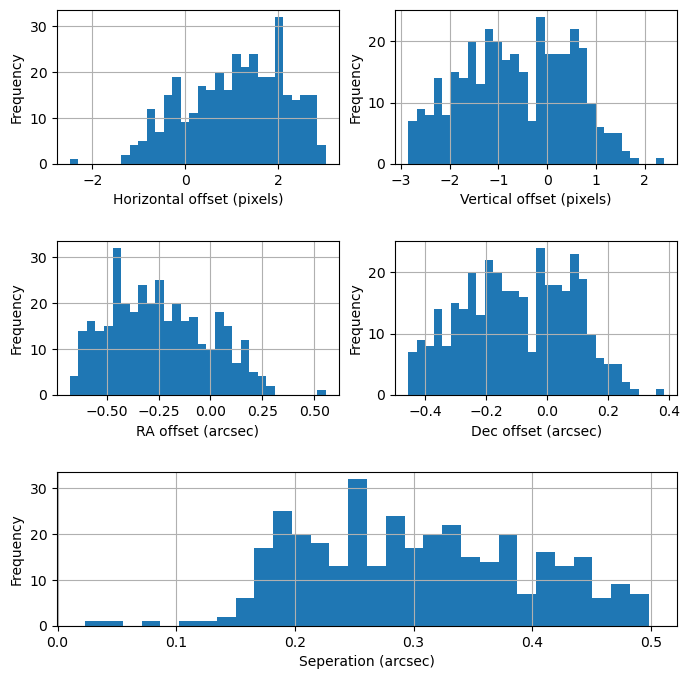

INFO: Auto-setting vmax to  1.330e+03 [aplpy.core]


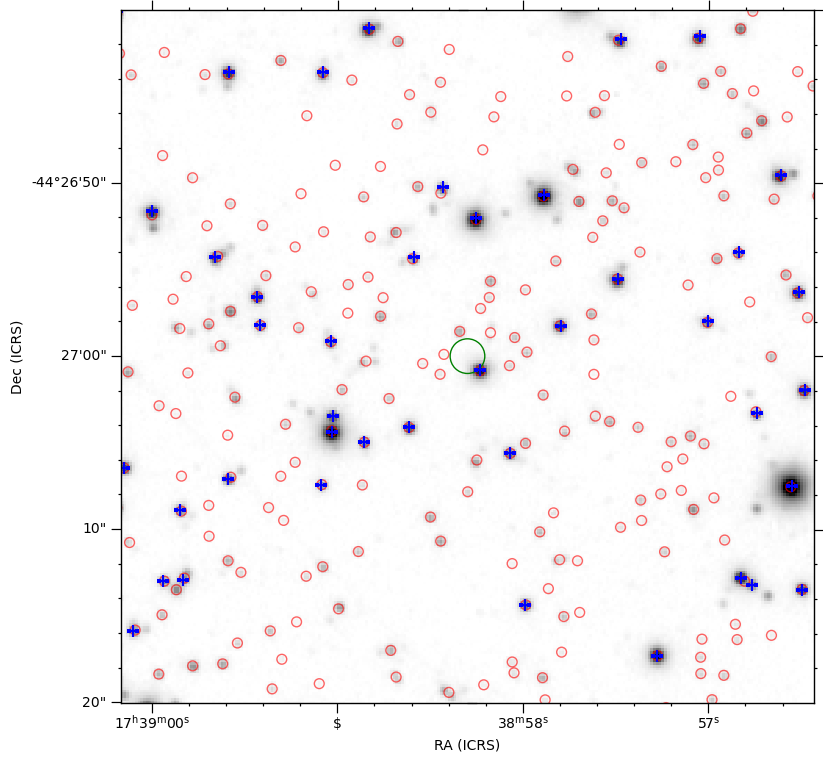

In [11]:
"""
Perform visual checks to see if astrometic calibration went OK. 

First we plot the distributions of horizontal pixel offsets, vertical pixel 
offsets, RA offsets, Dec offsets and separations between GDR3 and calibrated 
FourStar positions of their FourStar counterparts.

Second we plot the calibrated image, showing the GD3 sources (blue crosses), 
the literature error circle (green circle), and detected sources with 
SExtractor (red circles) on u018918.
"""

# Create 3x2 sub plots
gs = gridspec.GridSpec(3, 2)
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[1, 0]) 
ax4 = fig.add_subplot(gs[1, 1]) 
ax5 = fig.add_subplot(gs[2, :])
fig.subplots_adjust(hspace=.5)

# Plot distributions of horizontal and vertical pixel shifts, RA and Dec deviations,
# and separations between 2MASS and calibrated FourSTAR positions.
bins = 30

n1, bins1, patches1 = ax1.hist(hor_pixdiff_list, bins=bins)
ax1.set_xlabel("Horizontal offset (pixels)")
ax1.set_ylabel("Frequency")
ax1.grid(True)

n2, bins2, patches2 = ax2.hist(ver_pixdiff_list, bins=bins)
ax2.set_xlabel("Vertical offset (pixels)")
ax2.set_ylabel("Frequency")
ax2.grid(True)
          
n3, bins3, patches3 = ax3.hist(ra_diffvals_list, bins=bins)
ax3.set_xlabel("RA offset (arcsec)")
ax3.set_ylabel("Frequency")
ax3.grid(True)
          
n4, bins4, patches4 = ax4.hist(dec_diffvals_list, bins=bins)
ax4.set_xlabel("Dec offset (arcsec)")
ax4.set_ylabel("Frequency")
ax4.grid(True)

ax5.hist(d2d_gaia_cut.arcsec, bins=bins)
ax5.set_xlabel("Seperation (arcsec)")
ax5.set_ylabel("Frequency")
ax5.grid(True)

plt.savefig(figname_astro_offsets)
plt.show()


# Image stamp from astrometrically calibrated image:
gc2 = aplpy.FITSFigure(flname.split(".fits")[0] + "_astrocal.fits")
gc2.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1)

# Plot the FourStar sources
gc2.show_markers(coo_image_cal.ra.deg, coo_image_cal.dec.deg, edgecolor='r', facecolor='none', marker='o', s=50, alpha=0.6)
    
# Plot the XRB source and recenter on it
gc2.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600., edgecolor='g', facecolor='none', alpha=1)
gc2.recenter(XRB_coo.ra.deg, XRB_coo.dec.deg, radius=20/3600.)

# Plot the GDR3 sources
gc2.show_markers(coo_gaia.ra.deg, coo_gaia.dec.deg, edgecolor='b', facecolor='b', marker='+', s=80, alpha=1,label="2MASs")

gc2.set_theme('publication')
gc2.savefig(figname_astrometry.split('.png')[0] + '_astrocal.png') 

## Section 4: Calibrate zero point with 2MASS <a class="anchor" id="section4"></a>
Corrections for any offsets in the zero point are made. This ensures that the FourStar fluxes are reliable. The zero point offset is computed by fitting a line FourStar_mag = 2MASS_mag + offset to the FourStar and 2MASS magnitudes using orthogonal distance regression, which considers both errors in 2MASS and Fourstar magnitudes. This involves ruling out data points with infinite 2MASS error bars, suffer from non-linearity (these data points correspond to sources that are so bright, typically <13 mag, that not all photons are registered by the FourStar camera. Hence, these sources are detected with too high FourStar magnitudes), and bad matches as a consequence of possibly poor-quality sky matches.

In [12]:
"""
Parameters for zero point calibration.
"""

low_lim = 13.0 # The 2MASS magnitude cut-off below which non-linearity occurs. 
               # default: 13.0
first_cut_low = 3.0 # Number of magnitudes below the initial mean line below 
                    # which all bad matches are excluded during the first cut. Default: 3.0
first_cut_up = 3.0 # Number of magnitudes above the initial mean line above 
                   # which all bad matches are excluded during the first cut. Default: 3.0
rel_err_max = 3.0 # The maximum relative FourSTAR magnitude error at which 
                 # data points are included for fitting. Default: 3.0
abs_err = 0.5 # The maximum absolute FourSTAR magnitude error at which 
              # data points are included for fitting. Default: 0.5
mag_error_level = 0.682 # The inclusion level of the outputted zero point error. default: 0.682

Number of 2MASS sources retrieved: 1562
INFO: Auto-setting vmax to  1.192e+03 [aplpy.core]


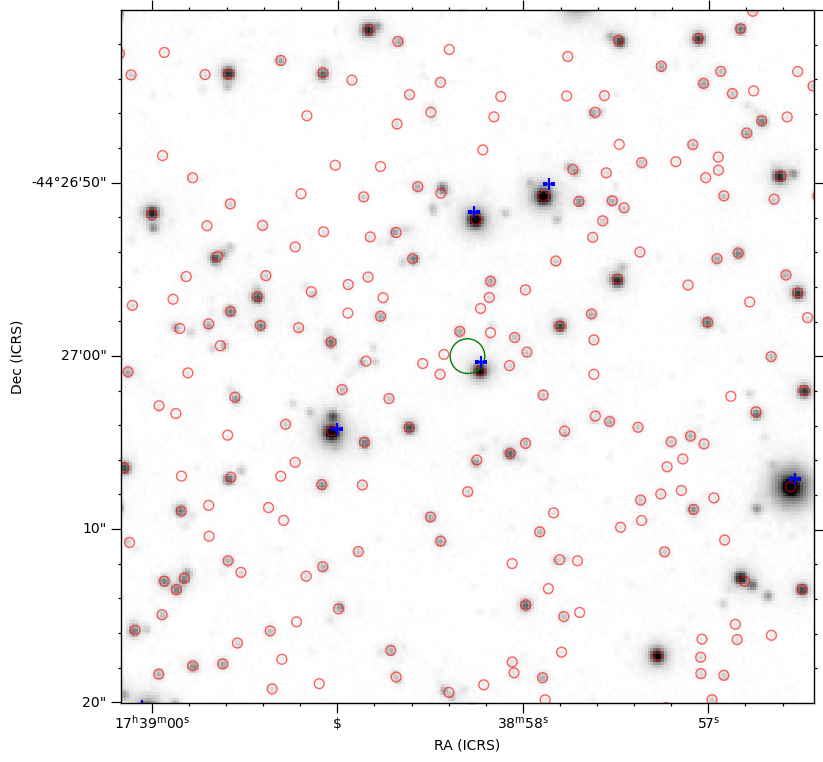

In [13]:
"""
Let's query the 2MASS database and retrieve sources within 
a 5 arcmin circular region around the XRB position. Perform nearest
neighbour matching between FourStar and 2MASS (just as before with GDR3).
"""

# Do a search around the XRB position
result_2MASS = ConeSearch.query_region(XRB_coo, 5 * u.arcmin)

# Transform into pandas dataframe (nicer to handle the table, imo)
#twomass = result.to_table().to_pandas() # If the table conversion below does not work, try this one.
twomass = result_2MASS.to_pandas()
print("Number of 2MASS sources retrieved:", len(twomass))

# Get the source data AND put them into a coordinate object
coo_twomass = SkyCoord(twomass['ra'].values*u.deg,
                       twomass['dec'].values*u.deg,frame=ICRS)

# Match u018918 to 2MASS
idx_twomass, d2d_twomass, d3d_twomass = coo_image_cal.match_to_catalog_sky(coo_twomass)

# Plot the FourStar image
gc = aplpy.FITSFigure(flname.split(".fits")[0] + "_astrocal.fits")
gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1)

# Plot the FourStar sources
gc.show_markers(coo_image_cal.ra.deg, coo_image_cal.dec.deg, edgecolor='r', facecolor='none', marker='o', s=50, alpha=0.6)

# Plot the XRB source coordinate and recenter on it
gc.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600., edgecolor='g', facecolor='none', alpha=1)
gc.recenter(XRB_coo.ra.deg, XRB_coo.dec.deg, radius=20/3600.)

# Plot the 2MASS sources
gc.show_markers(coo_twomass.ra.deg, coo_twomass.dec.deg, edgecolor='b', facecolor='b', marker='+', s=80, alpha=1,label="GDR3")

gc.set_theme('publication')
gc.savefig(figname_astrometry.split('GDR3.png')[0] + '_2MASS.png')

In [14]:
"""
Perform a quality cut for the sky matches in the previous cell:
1) Only select those stars with an angular separation of less than 1 arcsec
2) The catalogs by default give a magnitude of 99 to all sources without
   a magnitude. These stars are excluded by only selecting stars with a
   magnitude below 25.

For matched sources, given the filter in which the current observation 
has been taken, the appropriate 2MASS magnitudes and magnitude
error lists are selected and the above quality cut performed.
"""

# Quality cut for u019019 - 2MASS, and selecting appropriate 2MASS
# magnitudes and magnitude errors depending on the filter
if band == 'J':
    ss = (d2d_twomass.arcsec < 1.) & (twomass.JMag[idx_twomass] < 25.)
    twomass_mags = twomass.JMag[idx_twomass][ss]
    twomass_magserr = twomass.JMagErr[idx_twomass][ss]
elif band == 'H':
    ss = (d2d_twomass.arcsec < 1.) & (twomass.HMag[idx_twomass] < 25.)
    twomass_mags = twomass.HMag[idx_twomass][ss]
    twomass_magserr = twomass.HMagErr[idx_twomass][ss]
elif band == 'Ks':
    ss = (d2d_twomass.arcsec < 1.) & (twomass.KMag[idx_twomass] < 25.)
    twomass_mags = twomass.KMag[idx_twomass][ss]
    twomass_magserr = twomass.KMagErr[idx_twomass][ss]

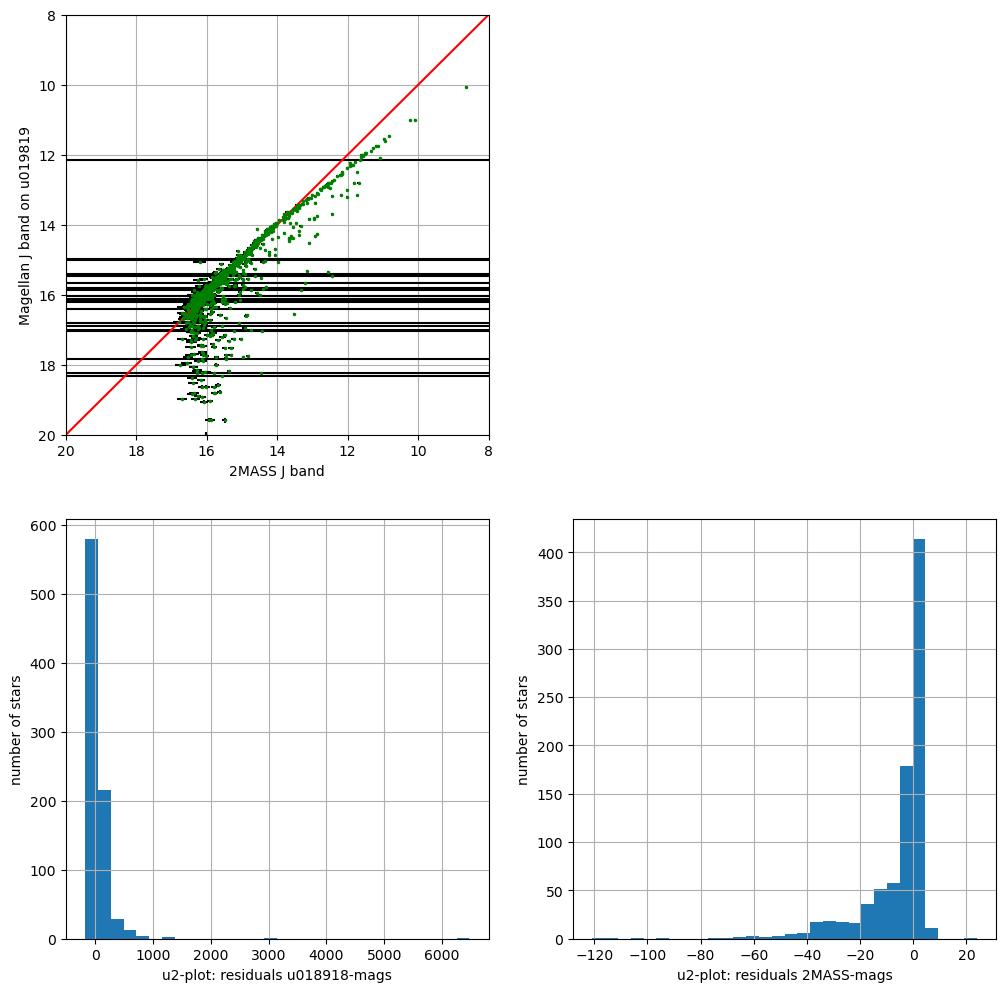

In [15]:
"""
Plot the observed FourStar magnitude vs the 2MASS magnitudes of the quality
cutted matches. Bad quality sky matches may cause scatter in the plots. 
Also note that stars with 2MASS magniudes below ~13 often have higher FourSTAR 
magnitudes. This is caused by nonlinearity of the FourSTAR camera for bright 
sources. In the plots, keep an eye on the following:
- Is the bulk of the magnitudes located on the red x=y line?
- Is there are a systematic offset between the 2MASS and FourStar magnitudes?

Besides the scatter plots, create two histograms showing relative errors of the data
points. One histogram shows the relative errors of the FourStar magnitudes, which 
are (u018918_mag - 2MASS_mag) / err_u018918_mag; and the other one shows the 
residuals of the 2MASS magnitudes, which are (2MASS_mag - u018918_mag) / err_2MASS_mag. 
"""

# Plotting observed vs expected 2MASS stars. This *may* contain variable stars.
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[1, 0]) 
ax3 = fig.add_subplot(gs[1, 1]) 

# Plot matched sources between FSRED on u018918 and 2MASS
ax1.errorbar(twomass_mags, data['MAG_AUTO'][ss], yerr=data['MAGERR_AUTO'][ss], xerr=twomass_magserr, color='g', ecolor='k', ls="None",marker="o", ms=1.5)
xx = np.linspace(0,20,100)
ax1.plot(xx,xx,'r')
ax1.set_ylabel("Magellan " + band + " band on u019819")
ax1.set_xlabel("2MASS " + band + " band")
ax1.set_xlim(20,8)
ax1.set_ylim(20,8)
ax1.grid(True)

# Histograms of relative errors between SExtractor and 2MASS magnitudes
dist_FS = [(list(data['MAG_AUTO'][ss])[i] - list(twomass_mags)[i]) / list(data['MAGERR_AUTO'][ss])[i] for i in range(len(data['MAG_AUTO'][ss]))]
dist_2MASS = [(list(twomass_mags)[i] - list(data['MAG_AUTO'][ss])[i]) / list(twomass_magserr)[i] for i in range(len(data['MAG_AUTO'][ss]))]

bins = 30

n1, bins1, patches1 = ax2.hist(dist_FS, bins=bins)
ax2.set_xlabel("u2-plot: residuals u018918-mags")
ax2.set_ylabel("number of stars")
ax2.grid(True)

n2, bins2, patches2 = ax3.hist(dist_2MASS, bins=bins)
ax3.set_xlabel("u2-plot: residuals 2MASS-mags")
ax3.set_ylabel("number of stars")
ax3.grid(True)

plt.savefig(figname_mags)
plt.show()

In [16]:
""" 
Perform the zero point calibration for the u018918 data. This involves the 
following steps, which are also indicated in the code flow:

STEP 1: Given the lists of (quality cutted) magnitudes from th matches,
perform another quality cut to get rid of all data points that have 
infinite 2MASS error bars, suffer from non-linearity, and have FourStar 
magnitudes that deviate too much from their 2MASS counterparts and 
may therefore bias the fitting procedure. 
- Data points with infinite 2MASS error bars are recognized by the value of 
  -999 for their 2MASS magnitude errors, and are removed by excluding all 
  data points with negative 2MASS magnitude errors. 
- Non-linearity is accounted for by excluding all data points with a 2MASS 
  magnitude above 'low_lim'.
- A first cut to exclude bad matches is made the following way. First 
  the means of the 2MASS magnitudes and FourStar magnitudes are calculated. 
  The point (mean_2MASS, mean_FS) is close to the y = x + a line. 
  Therefore, to exclude bad matches, we assume this line to go through 
  (mean_2MASS, mean_FourStar), and exclude every data point with a FourStar 
  magnitude at least 'first_cut_low' magnitudes below this line, and 
  'first_cut_up' magnitudes above this line.
  Note: higher FourStar magnitude means lower on the axis, and vice versa,
  since the y-axis is reversed.

STEP 2: Given the cleaned dataset from STEP 1, which still contains bad 
matches, a first fit is performed. Subsequently, each FourStar magnitude in 
the cleaned data is corrected for this offset and then evaluated on whether 
its FourStar relative magnitude error,
(FourStar_mag_corrected - 2MASS_mag) / err_2MASS_mag, is below 
'rel_err_max', and whether its absolute magnitude error, 
(FourSTAR_mag_corrected - 2MASS_mag), is below 'abs_err'. If so, this data 
point, with its uncorrected FourSTAR magnitude, is stored in 'goodmatch' 
lists, and a fit is performed on only those 'goodmatch' data points. This 
will provide a slightly better fit. Then again each FourSTAR magnitude in 
the cleaned dataset from STEP 1 is corrected and their relative errors and 
absolute errors evaluated to include the bulk of the magnitudes even better 
and exclude more bad matches, which will lead again to a better fit. This 
procedure is repeated until the 'goodmatch' lists remain the same w.r.t. a 
previous time, which means that the optimal fit is reached.

STEP 3: Subtract the resultant magnitude offset (or 'zero point offset') 
from the FourSTAR data to obtain calibrated magnitudes.

STEP 4: Perform bootstrapping on the calibrated 'goodmatch' data to compute 
a distribution that indicates the spread in the zero point error. Then, 
this distribution is flipped around its mean to a one-sided distribution. 
The zero point error is then calculated as the error at which a fraction of
'mag_error_level' of this distribution is included.
"""

# The model function
def func(a, x): return x + a[0]
    
# STEP 1
# Lists that will contain the data cleaned from data points that have 
# infinite error bars, that suffer from non-linearity, and are too far from the
# y = x + a line.
mag_firstcut_2MASS = []
mag_firstcut_FS = []
magerr_firstcut_2MASS = []
magerr_firstcut_FS = []

# Calculate the means of 2MASS and FourStar magnitudes
mean_FS = np.mean(data['MAG_AUTO'][ss])
mean_2MASS = np.mean(twomass_mags)

# For each 2MASS magnitude in the list of 2MASS magnitudes corresponding to the
# match, accept a data point only if it doesn't have infinite 2MASS error bars,
# does not suffer from non-linearity, and is not too far from the y = x + a line.
for i in range(len(list(twomass_mags))):
    cut_up = mean_FS + (list(twomass_mags)[i] - mean_2MASS) + first_cut_up
    cut_low = mean_FS + (list(twomass_mags)[i] - mean_2MASS) - first_cut_low
    if list(twomass_mags)[i] > low_lim and list(twomass_magserr)[i] > 0 \
    and list(data['MAG_AUTO'][ss])[i] < cut_up and list(data['MAG_AUTO'][ss])[i] > cut_low:
        mag_firstcut_2MASS.append(list(twomass_mags)[i])
        mag_firstcut_FS.append(list(data['MAG_AUTO'][ss])[i])
        magerr_firstcut_2MASS.append(list(twomass_magserr)[i])
        magerr_firstcut_FS.append(list(data['MAGERR_AUTO'][ss])[i])

                    
# STEP 2
# Initialize the final data lists (which will ultimately contain approximately 
# only good matches) to be the cleaned data lists.
mag_goodmatch_2MASS = mag_firstcut_2MASS
mag_goodmatch_FS = mag_firstcut_FS
magerr_goodmatch_2MASS = magerr_firstcut_2MASS
magerr_goodmatch_FS = magerr_firstcut_FS
array_compare = [[], mag_goodmatch_2MASS]

# Perform the fitting, while throwing out bad matches.
iterations = 0
while array_compare[1] != array_compare[0]:
    model = Model(func)
    realdata = RealData(mag_goodmatch_2MASS, mag_goodmatch_FS, sx=magerr_goodmatch_2MASS, sy=magerr_goodmatch_FS)
    odr = ODR(realdata, model, beta0=[0.0])
    out = odr.run()
    offset_zp = out.beta[0]
        
    # Calculate absolute and relative magnitude errors
    dist = [((mag_firstcut_FS[i] - offset_zp) - mag_firstcut_2MASS[i]) for i in range(len(mag_firstcut_FS))]
    rel_dist = [((mag_firstcut_FS[i] - offset_zp) - mag_firstcut_2MASS[i]) / magerr_firstcut_2MASS[i] for i in range(len(mag_firstcut_FS))]
    
    # Lists that will contain the 'goodmatch' data points.
    mag_goodmatch_2MASS = []
    mag_goodmatch_FS = []
    magerr_goodmatch_2MASS = []
    magerr_goodmatch_FS = []
    for i in range(len(dist)):
        if (abs(rel_dist[i]) < rel_err_max) and (abs(dist[i]) < abs_err):
            mag_goodmatch_2MASS.append(mag_firstcut_2MASS[i])
            mag_goodmatch_FS.append(mag_firstcut_FS[i])
            magerr_goodmatch_2MASS.append(magerr_firstcut_2MASS[i])
            magerr_goodmatch_FS.append(magerr_firstcut_FS[i])
            
    # Store lists to compare if they changed            
    array_compare[0] = array_compare[1]
    array_compare[1] = mag_goodmatch_2MASS
    iterations += 1

    
# STEP 3    
# Apply magnitude offset to u018918 data
mag_goodmatch_FS = list(np.array(mag_goodmatch_FS) - offset_zp)
data_magscal = list(data['MAG_AUTO'] - offset_zp)
        
    
# STEP 4
# Perform bootstrapping on the calibrated 'goodmatch' dataset to 
# calculate the magnitude error.
indices = np.arange(len(mag_goodmatch_FS)) 
twomass_arr = np.zeros(1000)
offset_zp_arr = np.zeros(1000)
for i in range(1000):
    new_indices = np.random.choice(indices, size=len(mag_goodmatch_2MASS), replace=True)
    
    new_mag_goodmatch_2MASS = np.take(mag_goodmatch_2MASS, new_indices)
    new_mag_goodmatch_FS = np.take(mag_goodmatch_FS, new_indices)
    new_magerr_goodmatch_2MASS = np.take(magerr_goodmatch_2MASS, new_indices)
    new_magerr_goodmatch_FS = np.take(magerr_goodmatch_FS, new_indices)
    
    model = Model(func)
    realdata = RealData(new_mag_goodmatch_2MASS, new_mag_goodmatch_FS, sx=new_magerr_goodmatch_2MASS, sy=new_magerr_goodmatch_FS)
    odr = ODR(realdata, model, beta0=[0.0])
    out = odr.run()
    offset_zp_dummy = out.beta[0]
    offset_zp_arr[i] = offset_zp_dummy
    
# Compute the zero point error for the u018918 data.
offset_zp_arr_abs = [abs(i - np.mean(offset_zp_arr)) for i in offset_zp_arr]
mag_error_cut = math.ceil(mag_error_level*len(offset_zp_arr_abs))
err_mag_zp = sorted(offset_zp_arr_abs)[mag_error_cut - 1]
print("Zeropoint offset u018918: " + str(offset_zp) + ' +/- ' + str(err_mag_zp))
print("Amount of sources used for calculation: " + str(len(mag_goodmatch_2MASS)))
print("Amount of fitting iterations: " + str(iterations))

Zeropoint offset u018918: -0.06311344376244743 +/- 0.003800413350362855
Amount of sources used for calculation: 498
Amount of fitting iterations: 9


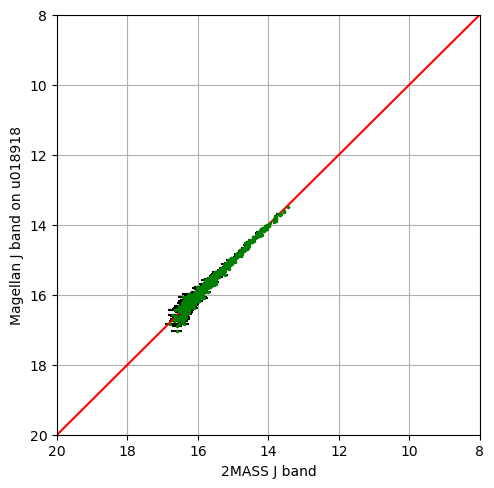

In [17]:
"""
Plot the calibrated 'goodmatch' magnitudes.
"""

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)

# Matched sources between FSRED on u018918 and 2MASS
ax1.errorbar(mag_goodmatch_2MASS,mag_goodmatch_FS, yerr=magerr_goodmatch_FS, xerr=magerr_goodmatch_2MASS,
             color='g',ecolor='k',ls="None",marker="o",ms=1.5)

ax1.set_ylabel("Magellan " + band + " band on u018918")
ax1.set_xlabel("2MASS " + band + " band")
xx = np.linspace(0,20,100)
ax1.plot(xx,xx,'r')
ax1.set_xlim(20,8)
ax1.set_ylim(20,8)
ax1.grid(True)

plt.savefig(figname_mags.split('.png')[0] + '_cal.png') 

## Section 5: Extract XRB counterparts <a class="anchor" id="section5"></a>


In [18]:
"""
Extract positions, raw magnitudes, raw magnitude errors, calibrated 
magnitudes, and SExtractor flags of all FourSTAR counterparts 
within an extended error circle with a radius determined by both
the radius of the literature error circle 'radius' and the 
astrometric error. Each counterpart is labled as well. 
"""

# Optionally define another XRB error circle to inspect for possible 
# XRB counterparts
#XRB_coo = SkyCoord("258.30633115 -37.55867414", unit=(u.deg,u.deg))
radius = 1.8

# Calculate seperations between sources and XRB location
seps = XRB_coo.separation(coo_image_cal)

# Lists to store counterpart info
in_circle_names = []
in_circle_pos_ra = []
in_circle_pos_dec = []
in_circle_magsraw = []
in_circle_magscal = []
in_circle_magserr = []
in_circle_flags = []

# Find possible XRB counterparts
counter = 0
for i in range(len(seps)):
    if seps[i].arcsec < np.sqrt(radius**2 + err_astro**2):
        counter += 1
        in_circle_names.append('S' + str(counter))
        in_circle_pos_ra.append(coo_image_cal[i].ra)
        in_circle_pos_dec.append(coo_image_cal[i].dec)
        in_circle_magsraw.append(list(data['MAG_AUTO'])[i])
        in_circle_magscal.append(data_magscal[i])
        in_circle_magserr.append(list(data['MAGERR_AUTO'])[i])
        in_circle_flags.append(list(data['FLAGS'])[i])


## Section 6: Calculate upper limit if there are no detected counterparts <a class="anchor" id="section6"></a>


In [19]:
""" 
Obtain upper limit if there are no sources detected.
It does so by calculating the standard deviation of the 
background pixels aroud where the source should be, and 
then converting this to an upper limit by the method of 
https://www.gnu.org/software/gnuastro/manual/html_node/Upper-limit-magnitude-of-each-detection.html
""" 
aperture_diameter = 5 # pixels

if len(in_circle_names) == 0: 
    # Define center of square and square radius
    pixel_hor, pixel_ver = w.wcs_world2pix(XRB_coo.ra, XRB_coo.dec, 1, ra_dec_order=True)
    pixelradius = np.ceil(aperture_diameter/2) 
    pixel_hor_int, pixel_ver_int = int(np.around(pixel_hor)), int(np.around(pixel_ver))

    # Create pixels to sample
    x_range = np.arange(pixel_hor_int - pixelradius + 1, pixel_hor_int + pixelradius, 1)
    y_range = np.arange(pixel_ver_int - pixelradius + 1, pixel_ver_int + pixelradius, 1)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    ra_background, dec_background = w.wcs_pix2world(grid_x, grid_y, 1, ra_dec_order=True)

    # Visualize pixels to sample
    gc = aplpy.FITSFigure(flname.split(".fits")[0] + "_astrocal.fits")
    gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1)
    gc.show_markers(XRB_coo.ra.deg, XRB_coo.dec.deg, edgecolor='r', facecolor='r', marker='x', s=20, alpha=1)
    gc.show_markers(ra_background, dec_background, edgecolor='b', facecolor='b', marker='.', s=8, alpha=1)
    gc.set_theme('publication')

    # Plot XRB source and recenter on it
    gc.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600., edgecolor='g', facecolor='none', alpha=1)
    gc.recenter(XRB_coo.ra.deg, XRB_coo.dec.deg, radius=5/3600.)

    # Open the calibrated fits file to get pixel information
    hdulist = fits.open(flname.split(".fits")[0] + "_astrocal.fits") 
    fitsdata = hdulist[0].data
    hdulist.close()

    # Determine mean and std of pixel values within square
    pixelvalues = []
    for x in x_range:
        for y in y_range: 
            pixelvalue = fitsdata[int(y), int(x)] 
            pixelvalues.append(pixelvalue)     
    mean_pixel = np.mean(pixelvalues)
    std_pixel = np.std(pixelvalues)
    print('pixel value mean: ', mean_pixel, ', pixel value std: ', std_pixel)

    # Calculate magnitude upper limit
    header = fits.getheader(flname[:-4])
    zeropoint = header['MAGZP']
    upp_lim = -2.5 * np.log10(3 * std_pixel) + zeropoint - offset_zp # TODO double check:  if zp from 2mass then dont need offset
    print('upper limit: ', upp_lim)

In [20]:
""" 
Visualise how upper limit relates to FourStar magnitudes. 
""" 

if len(in_circle_names) == 0: 
    # Create 2x2 sub plots
    gs = gridspec.GridSpec(1, 2)
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[0, 1]) 
    fig.subplots_adjust(wspace=.5)

    bins=30

    # Plot the magnitudes and upper limit
    y, x, _ = ax1.hist(data_magscal, bins=bins, range=[5, 25])
    ax1.vlines(upp_lim, 0, 1.1*max(y), color='r', label='upper limit')
    ax1.set_ylim(0, 1.1*max(y))
    ax1.set_xlabel('Calibrated magnitude')
    ax1.set_ylabel('Number of stars')

    # Zoom in on the magnitude histogram
    y, x, _ = ax2.hist(data_magscal, bins=bins, range=[upp_lim - 3,upp_lim + 1])
    ax2.vlines(upp_lim, 0, 1.1*max(y), color='r', label='upper limit')
    ax2.set_ylim(0, 1.1*max(y))
    ax2.set_xlabel('Calibrated magnitude')
    ax2.set_ylabel('Number of stars')

    plt.savefig(figname_upplim) 
    plt.show()


## Section 7: De-redden magnitudes and calculate flux density <a class="anchor" id="section7"></a>


In [21]:
""" 
De-redden the calibrated FourStar magnitudes and the upper limit
using the method as in 
https://ui.adsabs.harvard.edu/abs/2010MNRAS.404.1591D.
""" 

# Calculate the optical extinction from the hydrogen column density
Av = nH / (1.79*10**(21))
Av_err = Av * np.sqrt((nH_err/nH)**2 + (0.03/1.79)**2)

# Translate visual extinction to infrared extinction in the used filter
if band == 'J':
    A = 0.282 * Av
    A_err = 0.282 * Av_err
elif band == 'H':
    A = 0.175 * Av
    A_err = 0.175 * Av_err
elif band == 'Ks':
    A = 0.112 * Av
    A_err = 0.112 * Av_err

# Deredden the calibrated magnitudes of all detected counterparts
in_circle_magsdered = []
for mag in in_circle_magscal:
    in_circle_magsdered.append(mag - A)

# Deredden de upper limit
if len(in_circle_magscal) == 0:    
    upp_lim_dered = upp_lim - A

In [22]:
""" 
Calculate flux density based on AB magnitude system
using     m_AB = -2.5 log10(F_nu) - 48.60 
and       F_lamb = F_nu * c / lamb_eff
and convert this flux density to flux. 
""" 

# Calculate flux density 
if band == 'J':
    W_eff = 2214.62 # A
    l_eff = 12287.26 # A
elif band == 'H':
    W_eff = 2769.45 # A 
    l_eff = 16039.55 # A
elif band == 'Ks':
    W_eff = 3163.40 # A
    l_eff = 21315.89 # A

c = 2.9979e18 # A/s
F_lamb_list = []
F_lamb_err_list = []
Flux_list = []
Flux_err_list = []
for i, mag in enumerate(in_circle_magsdered): 
    F_nu = 10**(-(mag+48.60)/2.5) # erg/s/cm2/Hz   
    F_lamb = F_nu * c / l_eff**2 # erg/s/cm2/A
    Flux = W_eff * F_lamb 
    
    F_lamb_list.append(F_lamb)
    Flux_list.append(Flux)

    # Propagate the error on the flux density
    F_nu_err = in_circle_magserr[i] * F_nu * np.log(10)/2.5
    F_lamb_err = F_nu_err * c / l_eff**2
    F_lamb_err_list.append(F_lamb_err)
    
    # Propagate the error on the flux  
    Flux_err = F_lamb_err * W_eff
    Flux_err_list.append(Flux_err)


## Section 8: Output: overview and finder chart <a class="anchor" id="section8"></a>
Overview of all interesting numbers and possible XRB counterparts, and creation of an XRB finder chart. Also, write the important numbers to a text file and save the calibrated positions to a new cataloge file. 

General:
90.0% astrometric error ("): 0.38217155328894165
68.2% zeropoint error (mag): -0.06311344376244743 +/- 0.003800413350362855
Extinction (mag): 0.4332402234636871 +/- 0.007261009331793639

Detected counterparts:
>>> S1:
RA, Dec: hms_tuple(h=17.0, m=38.0, s=58.42709748846147), dms_tuple(d=-44.0, m=-26.0, s=-59.900501486083044)
u018918:
	Raw mag: 22.224869 +/- 0.25329015
	Calibrated mag: 22.287983
	Calibrated & dereddened mag: 21.85474271721014
	Total mag error: 0.2534226977943541
	Spectral flux density per unit wavelength (erg/s/cm2/A): 1.3062008410122591e-18 +/- 3.047220872299622e-19
	Flux (erg/s/cm2): 2.892738506522569e-15 +/- 6.748436288212188e-16
	SExtractor detection flag: 0
>>> S2:
RA, Dec: hms_tuple(h=17.0, m=38.0, s=58.3418784905615), dms_tuple(d=-44.0, m=-26.0, s=-58.5696307329863)
u018918:
	Raw mag: 19.883802 +/- 0.04695645
	Calibrated mag: 19.946917
	Calibrated & dereddened mag: 19.513676356736507
	Total mag error: 0.047666272887656985
	Spectral flux density per unit w

C:\Users\Iris Reitsma\anaconda3\lib\site-packages\aplpy\overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


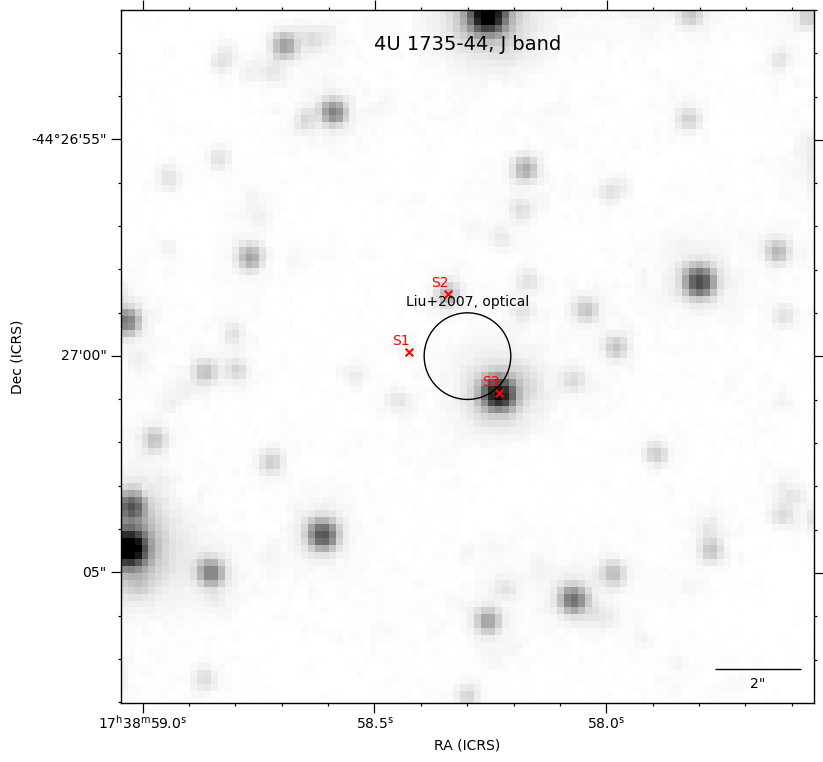

In [23]:
"""
Display all important numbers for this observation, and create a 
finder chart with all the detected counterparts. You need to play
with the parameters below to prepare a good-looking finder chart.
"""

# Finder chart parameters
chart_size = 8 # Half width of the finder chart in arcseconds; default: 8
label_size = 10 # Size of the labels of the counterparts, error circles and scale bar; default: 10
XRB_size = 14 # Size of the XRB name; default: 14
scale_size = 2 # Size of the scale bar in arcseconds; default: 2
context_color = 'k' # Color of the XRB name and angular scale bar; default: 'k'
errorcircle_color = 'k' # Color of error circles and their labels; default: 'k'
counterpart_color = 'r' # Color of counterpart markers and their labels; default: 'r'

# Print out the interesting numbers of this observation and detected possible XRB counterparts
print("General:")
print(str(100*astro_error_level) + '% astrometric error (\"): ' + str(err_astro))
print(str(100*mag_error_level) + '% zeropoint error (mag): ' + str(offset_zp) + ' +/- ' + str(err_mag_zp))
print('Extinction (mag): ' + str(A) + ' +/- ' + str(A_err))
print()

print("Detected counterparts:")
if in_circle_pos_ra:
    for i in range(len(in_circle_pos_ra)):
        print('>>> ' + in_circle_names[i] + ':')
        print('RA, Dec: ' + str(in_circle_pos_ra[i].hms) + ', ' + str(in_circle_pos_dec[i].dms))
        print('u018918:')
        print('\tRaw mag: ' + str(in_circle_magsraw[i]) + ' +/- ' + str(in_circle_magserr[i]))
        print('\tCalibrated mag: ' + str(in_circle_magscal[i]))
        print('\tCalibrated & dereddened mag: ' +  str(in_circle_magsdered[i]))
        print('\tTotal mag error: ' + str(np.sqrt(in_circle_magserr[i]**2 + err_mag_zp**2 + A_err**2)))
        print('\tSpectral flux density per unit wavelength (erg/s/cm2/A): ' + str(F_lamb_list[i]) + ' +/- ' + str(F_lamb_err_list[i]))
        print('\tFlux (erg/s/cm2): ' + str(Flux_list[i]) + ' +/- ' + str(Flux_err_list[i]))
        print('\tSExtractor detection flag: ' + str(in_circle_flags[i]))

else:
    print('>>> No detected counterparts')
    print('Calibrated upper limit: >' + str(upp_lim))
    print('Calibrated & dereddened upper limit: >' + str(upp_lim_dered))    

# Create finder chart using the astrometrically calibrated image
gc = aplpy.FITSFigure(flname.split(".fits")[0] + "_astrocal.fits")
gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1)
gc.add_label(0.50, 0.95, source.replace('_', ' ') + ', ' + band + ' band', relative=True, size=XRB_size, color=context_color)

# The error circles and their labels. They are added manually, 
# because the show_regions method shows offsetted regions. This 
# is because it doesn't seem to correct for the array indexing 
# difference between DS9 and Python, where arrays in DS9 start 
# at (1,1), whereas in Python at (0,0). 
reg_file = open(FSRED_dir + 'FSRED/Diagnostics/' + source + '/' + source + '.reg', 'r')
for line in reg_file:
    if "circle" in line:
        text = re.search('\{(.*)\}', line).group(1)
        source_reg = re.search('\((.*)\"', line).group(1)
        RA_str, Dec_str, rad_str = source_reg.split(',')
        
        for elem in 'hms':
            RA_str = RA_str.replace(elem, ' ')
        for elem in 'dms':
            Dec_str = Dec_str.replace(elem, ' ')

        reg_coord = SkyCoord(RA_str + ' ' + Dec_str, unit=(u.hourangle,u.deg))
        
        gc.show_circles(reg_coord.ra.deg, reg_coord.dec.deg, eval(rad_str)/3600., edgecolor=errorcircle_color, label=text, facecolor='none', alpha=1)
        gc.add_label(reg_coord.ra.deg, reg_coord.dec.deg + eval(rad_str)/3600. + (chart_size / 10.) * 0.32/3600, text, size=label_size, color=errorcircle_color)       
reg_file.close()

# Plot the counterparts
if in_circle_pos_ra:
    counterparts = SkyCoord(in_circle_pos_ra*u.deg, in_circle_pos_dec*u.deg,frame=ICRS)
    gc.show_markers(counterparts.ra.deg, counterparts.dec.deg, edgecolor=counterpart_color, facecolor=counterpart_color, marker='x', s=30, alpha=1)
    label_pos = (chart_size / 10.) * 0.32/3600 # Label position w.r.t. the counterpart position for good readability
    
# Only add labels if there is more than one counterpart
if len(in_circle_names) > 1: 
    for i in range(len(in_circle_names)):
        gc.add_label(in_circle_pos_ra[i].value + label_pos, in_circle_pos_dec[i].value + label_pos, in_circle_names[i], size=label_size, color=counterpart_color)

# Recentering on XRB source
gc.recenter(XRB_coo.ra.deg, XRB_coo.dec.deg, radius=chart_size/3600.)

# Add a scale bar
gc.add_scalebar(scale_size/3600., label=str(scale_size)+'\"', size=label_size, color=context_color)

gc.set_theme('publication')
gc.savefig(figname_finderchart) 

In [24]:
"""
Write important numbers to text file.
"""

with open(txtname, 'w') as f:
    # Write source information
    f.write('Source information:\n')
    f.write('Source: ' + source + '\n')
    f.write('Coordinates: ' + coords + '\n')
    f.write('Observation number: ' + obs + '\n')
    f.write('Band: ' + band + '\n')
    f.write('' + '\n')

    # Write general information 
    f.write("General:\n")
    f.write(str(100*astro_error_level) + '% astrometric error (\"): ' + str(err_astro) + '\n')
    f.write(str(100*mag_error_level) + '% zeropoint error (mag): ' + str(offset_zp) + ' +/- ' + str(err_mag_zp) + '\n')
    f.write('Extinction (mag): ' + str(A) + ' +/- ' + str(A_err) + '\n')
    f.write('' + '\n')
    
    # Write information about detected counterparts
    f.write("Detected counterparts:" + '\n')
    if in_circle_pos_ra:
        for i in range(len(in_circle_pos_ra)):
            f.write('>>> ' + in_circle_names[i] + ':' + '\n')
            f.write('RA, Dec: ' + str(in_circle_pos_ra[i].hms) + ', ' + str(in_circle_pos_dec[i].dms) + '\n')
            f.write('\tRaw mag: ' + str(in_circle_magsraw[i]) + ' +/- ' + str(in_circle_magserr[i]) + '\n')
            f.write('\tCalibrated mag: ' + str(in_circle_magscal[i]) + '\n')
            f.write('\tCalibrated & dereddened mag: ' +  str(in_circle_magsdered[i]) + '\n')
            f.write('\tTotal mag error: ' + str(np.sqrt(in_circle_magserr[i]**2 + err_mag_zp**2 + A_err**2)) + '\n')
            f.write('\tSpectral flux density per unit wavelength (erg/s/cm2/A): ' + str(F_lamb_list[i]) + ' +/- ' + str(F_lamb_err_list[i]) + '\n')
            f.write('\tFlux (erg/s/cm2): ' + str(Flux_list[i]) + ' +/- ' + str(Flux_err_list[i]) + '\n')
            f.write('\tSExtractor detection flag: ' + str(in_circle_flags[i]) + '\n')
            f.write('')
    else:
        f.write('>>> No detected counterparts' + '\n')
        f.write('Calibrated upper limit: >' + str(upp_lim) + '\n')
        f.write('Calibrated & dereddened upper limit: >' + str(upp_lim_dered) + '\n')
f.close()

In [25]:
"""
Store astrocalibrated pixel coordinates and calibrated and dereddened 
magnitude and error in new cats file. 
"""

data['X_IMAGE'] = data['X_IMAGE'] + hor_pix_shift_manual + hor_pix_shift 
data['Y_IMAGE'] = data['Y_IMAGE'] + ver_pix_shift_manual + ver_pix_shift
data['MAG_AUTO'] = [data_magscal[i] - A for i in range(len(data_magscal))]
data['MAGERR_AUTO'] = np.sqrt(data['MAGERR_AUTO']**2 + err_mag_zp**2 + A_err**2)

hdu = fits.BinTableHDU(data=data)
hdu.writeto(flname.split(".mos.fits.cat")[0] + "_calibrated.mos.fits.cat", overwrite=True)